# Case Study and Implementation

***Problem Statement***

Late skin cancer diagnosis in Africa, driven by limited diagnostic access, high treatment costs, and socio-cultural barriers, results in high mortality rates. In 2020, skin cancer accounted for approximately 10,000 deaths annually in Africa, with over 90% of cases diagnosed at advanced stages due to inadequate healthcare infrastructure (GLOBOCAN 2020). Current solutions, such as mobile health units and WHO screening programs, are constrained by insufficient funding, limited reach, and stigma, necessitating an accessible, low-cost, and accurate diagnostic tool for early detection to improve outcomes in underserved communities.

##### Model Diagram

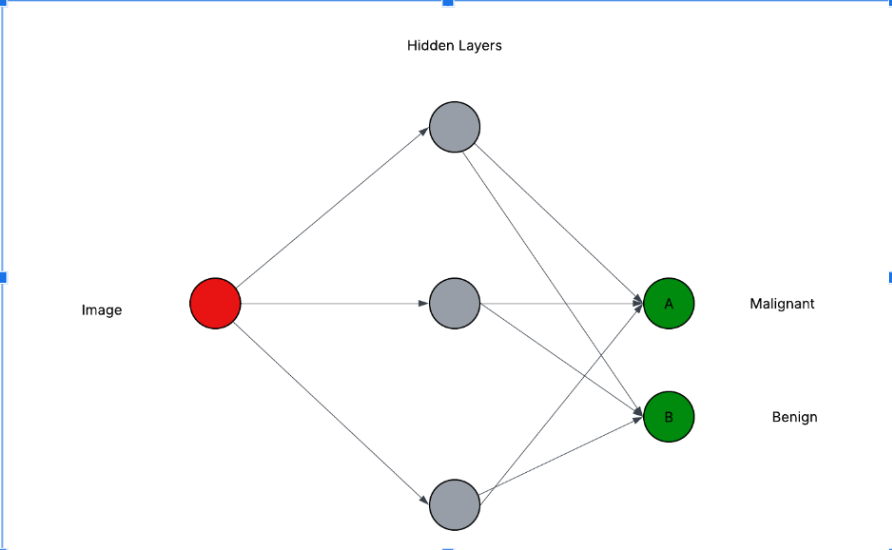

In [ ]:
# Core libraries
import os
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Google Colab integration
from google.colab import drive

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# XGBoost
from xgboost import XGBClassifier

# Keras / TensorFlow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utilities
import seaborn as sns
import joblib


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
dataset_path = '/content/drive/MyDrive/ISIC-images'
image_dir = os.path.join(dataset_path)
metadata_file = os.path.join(dataset_path, 'metadata.csv')
output_dir = os.path.join(dataset_path, 'organized_images')

# Create output directories
os.makedirs(os.path.join(output_dir, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'benign'), exist_ok=True)

# Read metadata
df = pd.read_csv(metadata_file)

# Function to determine if an image is malignant or benign
def get_label(row):
    if row['diagnosis_1'] == 'Malignant':
        return 'malignant'
    elif row['diagnosis_1'] == 'Benign':
        return 'benign'
    else:
        return None

# Sort images into subfolders
for idx, row in df.iterrows():
    image_name = row['isic_id'] + '.jpg'
    src_path = os.path.join(image_dir, image_name)
    label = get_label(row)
    if label and os.path.exists(src_path):
        dest_path = os.path.join(output_dir, label, image_name)
        shutil.copy(src_path, dest_path)

print("Images organized into malignant/ and benign/ subfolders.")

Mounted at /content/drive
Images organized into malignant/ and benign/ subfolders.


## Load Data (Separate into: Train, Validation, and Test Sets)

In [ ]:


# Preprocessing and splitting
preprocessed_dir = '/content/drive/MyDrive/ISIC-images/preprocessed_split'
target_size = (172, 251)  # Height, Width
test_size = 0.15
val_size = 0.15
random_seed = 42

# Create output folders
for split in ['train', 'val', 'test']:
    for label in ['malignant', 'benign']:
        os.makedirs(os.path.join(preprocessed_dir, split, label), exist_ok=True)

# Collect image paths and labels
image_paths = []
labels = []
for label in ['malignant', 'benign']:
    folder = os.path.join(output_dir, label)
    for fname in os.listdir(folder):
        if fname.lower().endswith('.jpg'):
            image_paths.append(os.path.join(folder, fname))
            labels.append(label)

# Split dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=test_size, stratify=labels, random_state=random_seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size / (1 - test_size), stratify=y_train_val, random_state=random_seed
)

# Function to preprocess and save images
def preprocess_and_save(images, labels, split_name):
    for path, label in zip(images, labels):
        img = Image.open(path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize
        img_norm = Image.fromarray((img_array * 255).astype(np.uint8))
        filename = os.path.basename(path)
        save_path = os.path.join(preprocessed_dir, split_name, label, filename)
        img_norm.save(save_path)

# Preprocess and save
preprocess_and_save(X_train, y_train, 'train')
preprocess_and_save(X_val, y_val, 'val')
preprocess_and_save(X_test, y_test, 'test')

print("Preprocessing complete: resized, normalized, and split into train/val/test.")

# Data generators
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(preprocessed_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    os.path.join(preprocessed_dir, 'val'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    os.path.join(preprocessed_dir, 'test'),
    target_size=target_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Preprocessing complete: resized, normalized, and split into train/val/test.
Found 139 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 56 images belonging to 2 classes.



Training Logistic Regression Model...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression Best Parameters: {'C': 10.0, 'solver': 'lbfgs'}

Logistic Regression Classification Report (Test Data):
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00        19
   malignant       1.00      1.00      1.00        37

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Logistic Regression ROC AUC: 1.0000


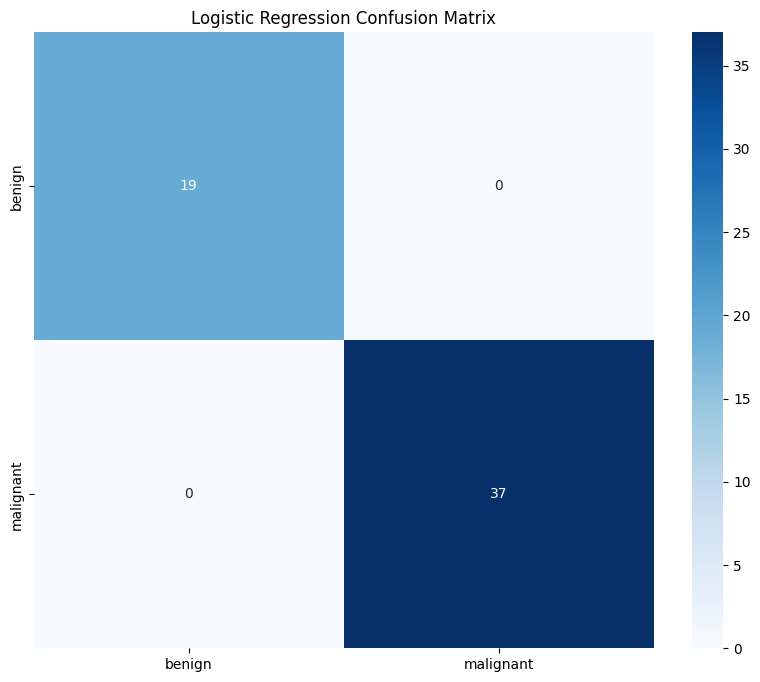

Logistic Regression model saved to /content/drive/MyDrive/saved_models/logistic_regression_model.pkl


In [ ]:
# Logistic Regression Model (Baseline Comparison)


# Function to load and preprocess images (same as used for XGBoost)
def load_data_from_folder(folder_path, target_size=(172, 251)):
    data = []
    labels = []
    for label in ['benign', 'malignant']:
        label_path = os.path.join(folder_path, label)
        for fname in os.listdir(label_path):
            if fname.endswith('.jpg'):
                img = Image.open(os.path.join(label_path, fname)).resize(target_size)
                img_array = np.array(img).flatten() / 255.0  # Flatten and normalize
                data.append(img_array)
                labels.append(label)
    return np.array(data), np.array(labels)

# Load data for train, validation, and test sets
X_train, y_train = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/train')
X_val, y_val = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/val')
X_test, y_test = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/test')

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Train Logistic Regression Model
print("\nTraining Logistic Regression Model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, scoring='f1_macro', cv=3, verbose=1, n_jobs=-1)
grid_lr.fit(X_train, y_train)

print(f"Logistic Regression Best Parameters: {grid_lr.best_params_}")

# Evaluate on test set
best_lr_model = grid_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

print("\nLogistic Regression Classification Report (Test Data):")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, best_lr_model.predict_proba(X_test)[:, 1]):.4f}")

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Save Logistic Regression model
lr_save_path = '/content/drive/MyDrive/saved_models/logistic_regression_model.pkl'
joblib.dump(best_lr_model, lr_save_path)
print(f"Logistic Regression model saved to {lr_save_path}")

# SECTION 1: Model Architecture

## Task: Define a function that creates models without and with specified optimization techniques

In [ ]:
def define_model(optimization: str, regularization_datatype, early_stopping: bool, dropout: float, learning_rate: float,
                 train_gen=None, val_gen=None, compute_metrics=False, model_save_path=None, **kwargs):
    """
    Define and optionally train a neural network model for binary classification.

    Parameters:
    - optimization: str, optimizer type ('adam' or 'rmsprop')
    - regularization_datatype: Keras regularizer (e.g., l2(0.01) or None)
    - early_stopping: bool, whether to fit with EarlyStopping callback
    - dropout: float, dropout rate (0.0 to 1.0)
    - learning_rate: float, optimizer learning rate
    - train_gen: Keras generator for training
    - val_gen: Keras generator for validation
    - compute_metrics: bool, whether to print evaluation metrics
    - model_save_path: str, path to save the trained model (optional)
    - **kwargs: catches additional parameters

    Returns:
    - Tuple of (compiled Keras Sequential model, training history or None)
    """
    if kwargs:
        warnings.warn(f"Unused parameters passed to define_model: {kwargs}", UserWarning)

    if early_stopping and (train_gen is None or val_gen is None):
        raise ValueError("train_gen and val_gen must be provided when early_stopping=True")

    model = Sequential()
    model.add(Flatten(input_shape=(172, 251, 3)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularization_datatype))
    model.add(Dense(1, activation='sigmoid'))

    if optimization.lower() == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimization.lower() == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimization}")

    model.compile(optimizer=optimizer_instance, loss='binary_crossentropy', metrics=['accuracy'])

    history = None
    if early_stopping:
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
        history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks, verbose=0)

    if compute_metrics and val_gen:
        y_true = val_gen.classes
        y_pred_probs = model.predict(val_gen)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        print("\nEvaluation Metrics on Validation Set:")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
        print(f"Precision: {precision_score(y_true, y_pred):.4f}")
        print(f"Recall: {recall_score(y_true, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_true, y_pred_probs):.4f}")

    if model_save_path:
        model.save(model_save_path)
        print(f"Model saved to {model_save_path}")

    return model, history

## Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
# Plot the loss curve
def loss_curve_plot(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def print_final_accuracy(history, title):
    print(f"{title} Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"{title} Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# SECTION 2: Optimization and Regularization Combinations

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step



Evaluation Metrics on Validation Set:
Accuracy: 0.6852
F1 Score: 0.8132
Precision: 0.6852
Recall: 1.0000
ROC AUC: 0.4595
Model saved to /content/drive/MyDrive/saved_models/model1.h5


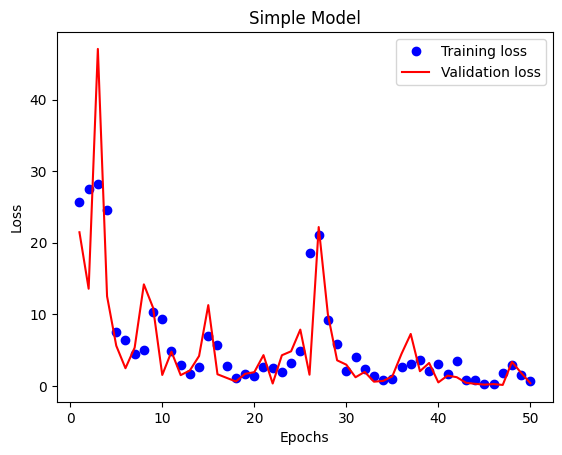

Simple Model Final Training Accuracy: 0.8489
Simple Model Final Validation Accuracy: 0.8519
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


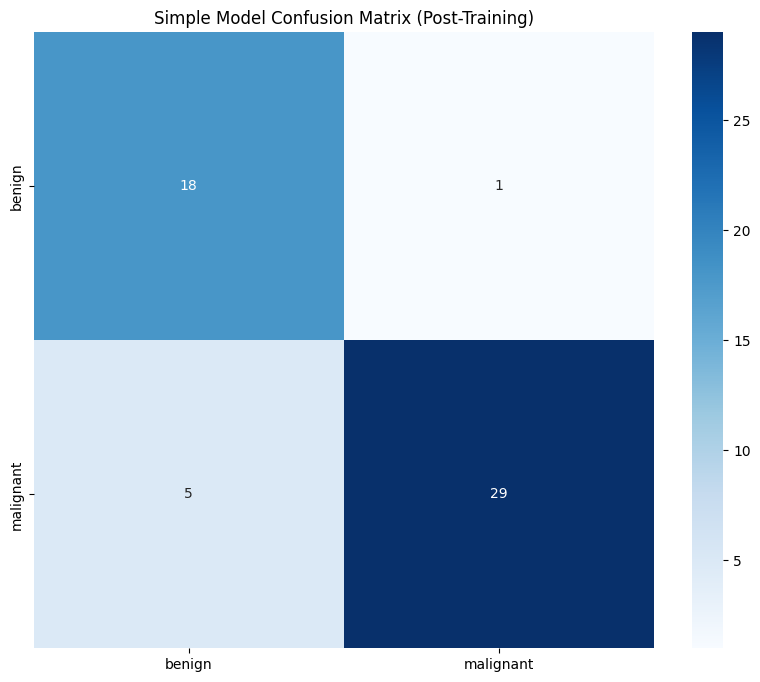

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step



Evaluation Metrics on Validation Set:
Accuracy: 0.6667
F1 Score: 0.7955
Precision: 0.6863
Recall: 0.9459
ROC AUC: 0.5270
Model saved to /content/drive/MyDrive/saved_models/model2.h5


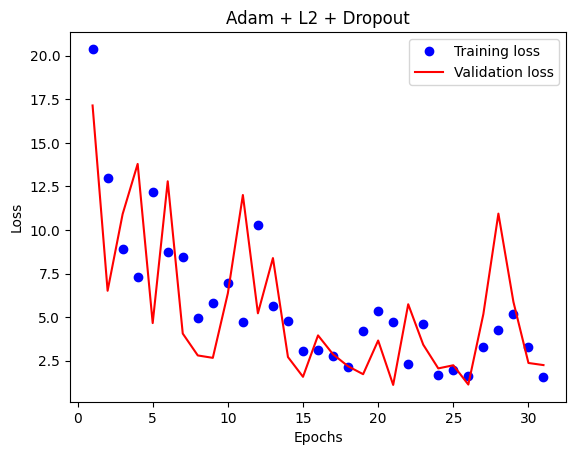

Adam + L2 + Dropout Final Training Accuracy: 0.7626
Adam + L2 + Dropout Final Validation Accuracy: 0.7037
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


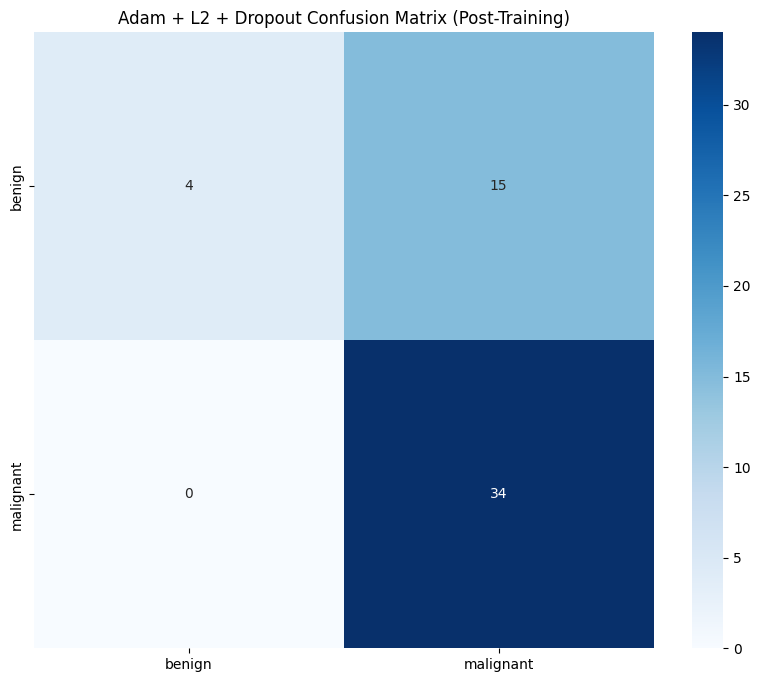

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step



Evaluation Metrics on Validation Set:
Accuracy: 0.6852
F1 Score: 0.8132
Precision: 0.6852
Recall: 1.0000
ROC AUC: 0.5024
Model saved to /content/drive/MyDrive/saved_models/model3.h5


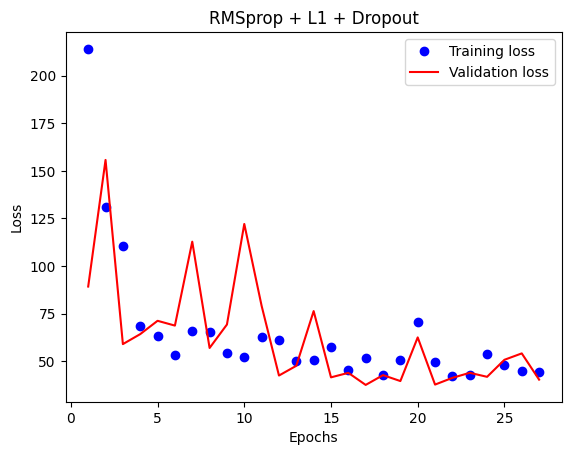

RMSprop + L1 + Dropout Final Training Accuracy: 0.5612
RMSprop + L1 + Dropout Final Validation Accuracy: 0.6852
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


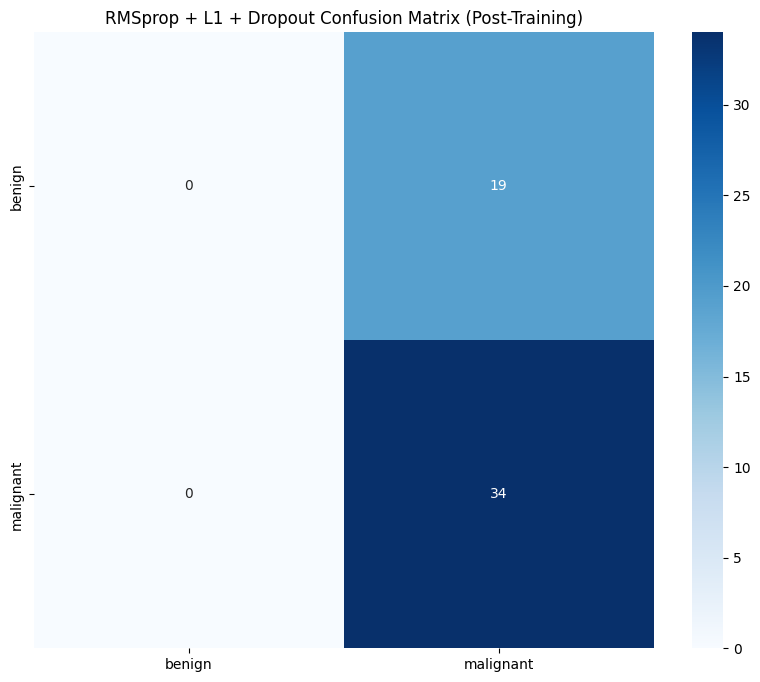

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Evaluation Metrics on Validation Set:
Accuracy: 0.4074
F1 Score: 0.4667
Precision: 0.6087
Recall: 0.3784
ROC AUC: 0.4086


Model saved to /content/drive/MyDrive/saved_models/model4.h5


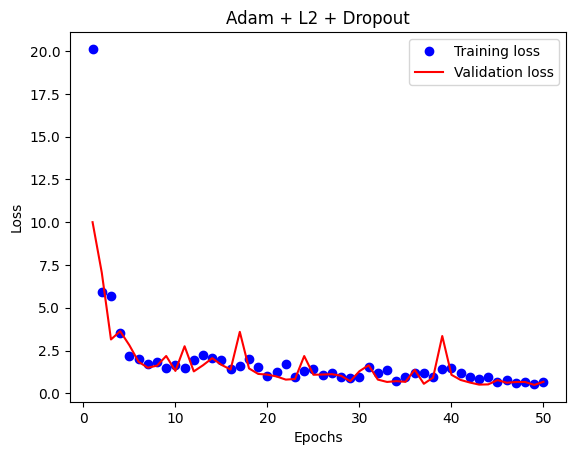

Adam + L2 + Dropout Final Training Accuracy: 0.8201
Adam + L2 + Dropout Final Validation Accuracy: 0.7407
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


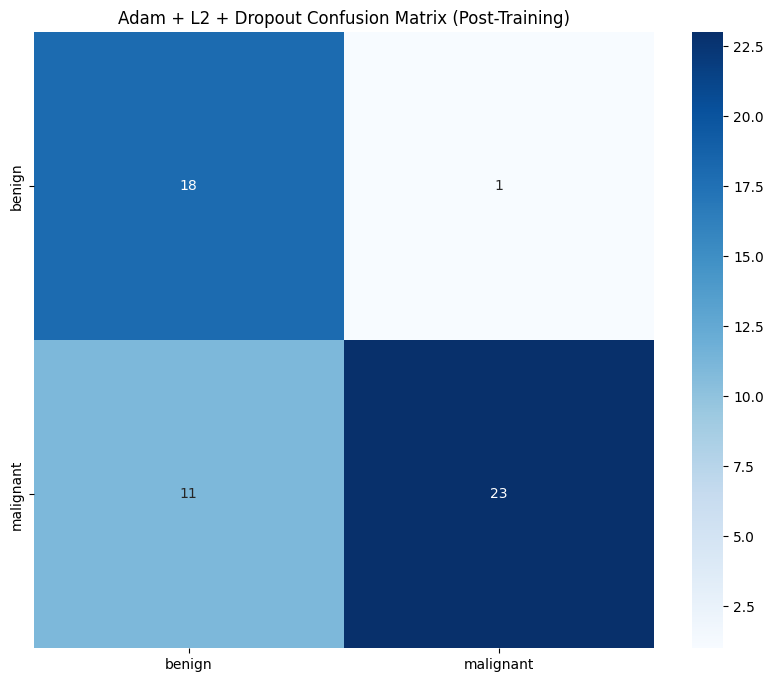

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Evaluation Metrics on Validation Set:
Accuracy: 0.4074
F1 Score: 0.4286
Precision: 0.6316
Recall: 0.3243
ROC AUC: 0.4340
Model saved to /content/drive/MyDrive/saved_models/optimized_cnn_model_4.h5


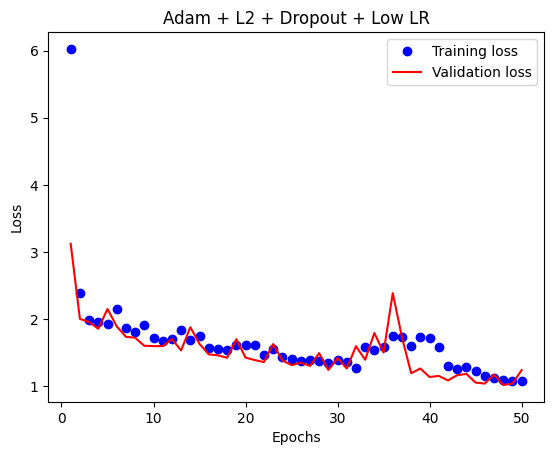

Adam + L2 + Dropout + Low LR Final Training Accuracy: 0.8129
Adam + L2 + Dropout + Low LR Final Validation Accuracy: 0.6667
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


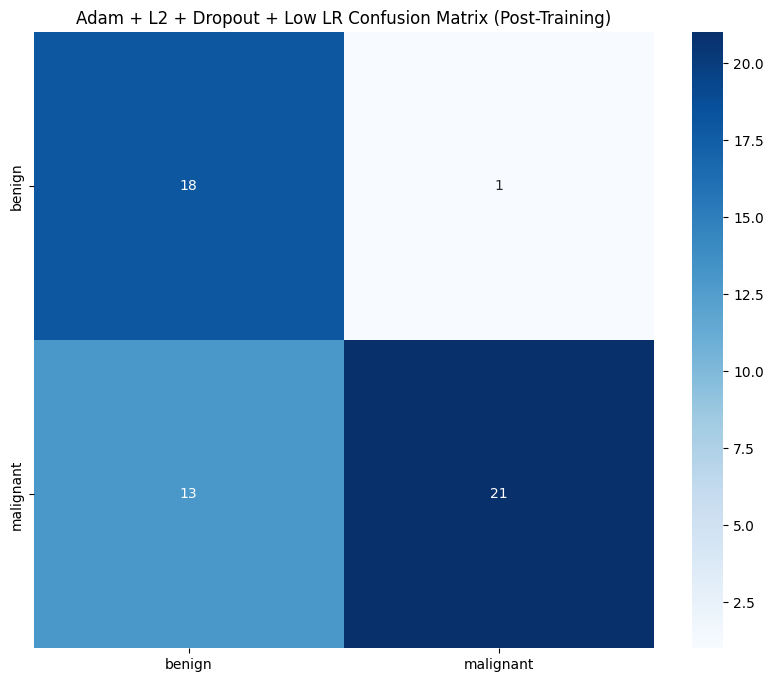

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Simple Model Test Results:
              precision    recall  f1-score   support

      benign       0.78      0.95      0.86        19
   malignant       0.97      0.85      0.91        34

    accuracy                           0.89        53
   macro avg       0.87      0.90      0.88        53
weighted avg       0.90      0.89      0.89        53

ROC AUC: 0.9706


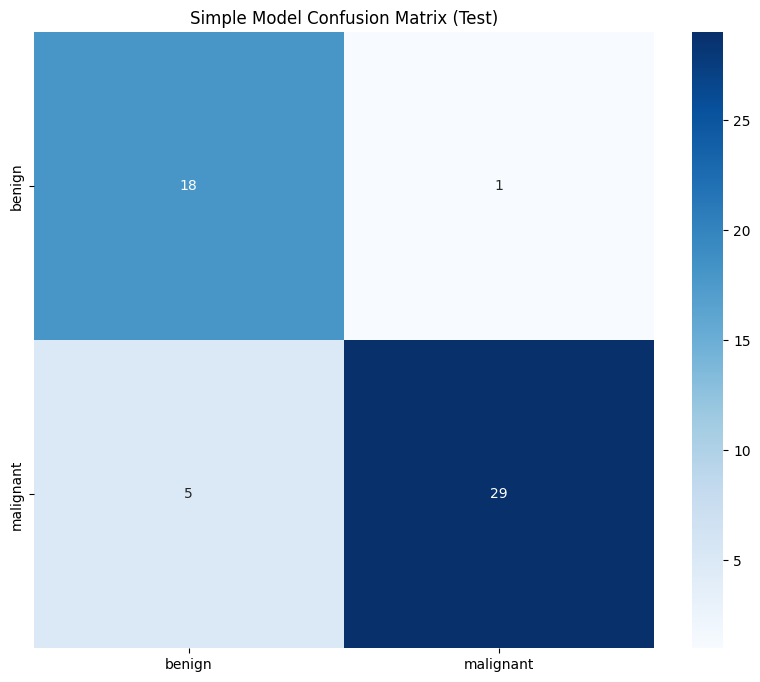

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Adam + L2 + Dropout Test Results:
              precision    recall  f1-score   support

      benign       1.00      0.21      0.35        19
   malignant       0.69      1.00      0.82        34

    accuracy                           0.72        53
   macro avg       0.85      0.61      0.58        53
weighted avg       0.80      0.72      0.65        53

ROC AUC: 0.9063


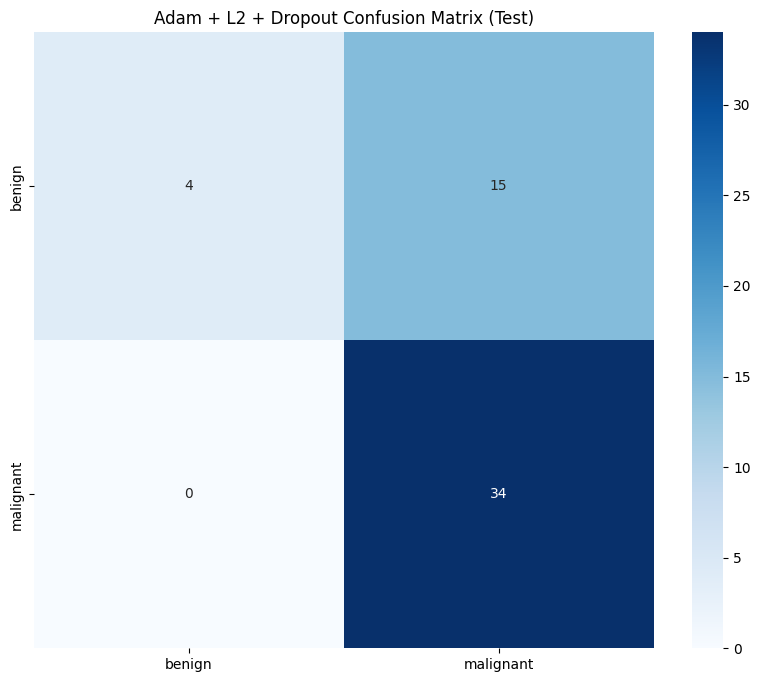

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

RMSprop + L1 + Dropout Test Results:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        19
   malignant       0.64      1.00      0.78        34

    accuracy                           0.64        53
   macro avg       0.32      0.50      0.39        53
weighted avg       0.41      0.64      0.50        53

ROC AUC: 0.3854


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


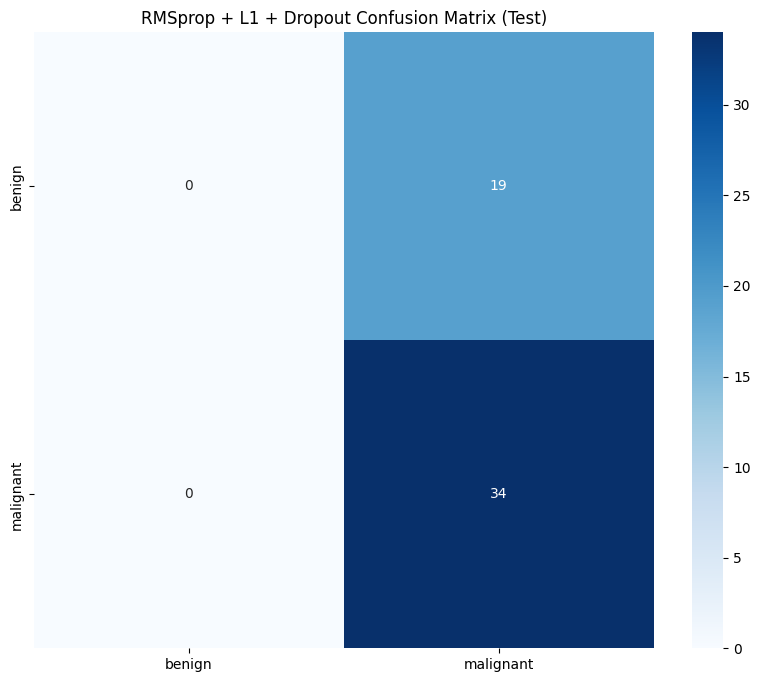

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Adam + L2 + Dropout Test Results:
              precision    recall  f1-score   support

      benign       0.62      0.95      0.75        19
   malignant       0.96      0.68      0.79        34

    accuracy                           0.77        53
   macro avg       0.79      0.81      0.77        53
weighted avg       0.84      0.77      0.78        53

ROC AUC: 0.9706


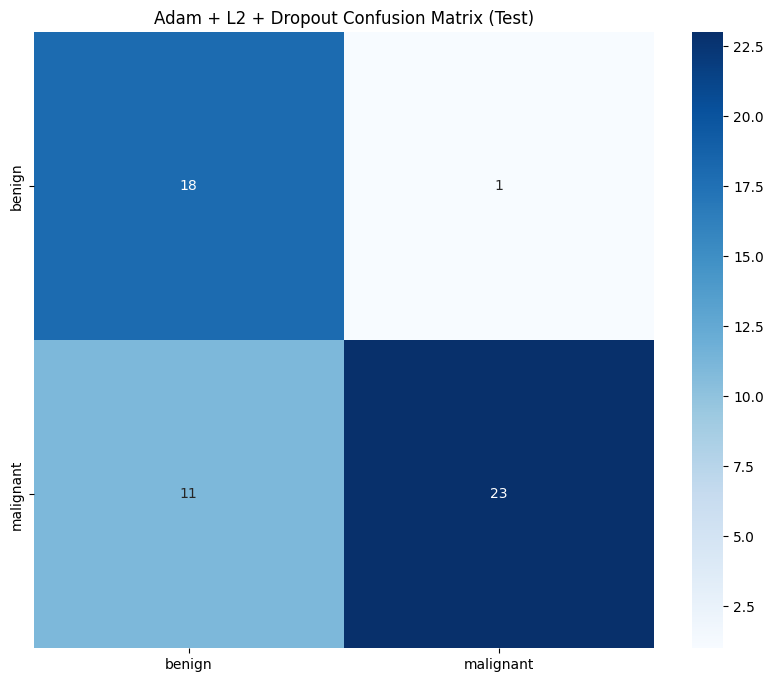

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Adam + L2 + Dropout + Low LR Test Results:
              precision    recall  f1-score   support

      benign       0.58      0.95      0.72        19
   malignant       0.95      0.62      0.75        34

    accuracy                           0.74        53
   macro avg       0.77      0.78      0.73        53
weighted avg       0.82      0.74      0.74        53

ROC AUC: 0.9272


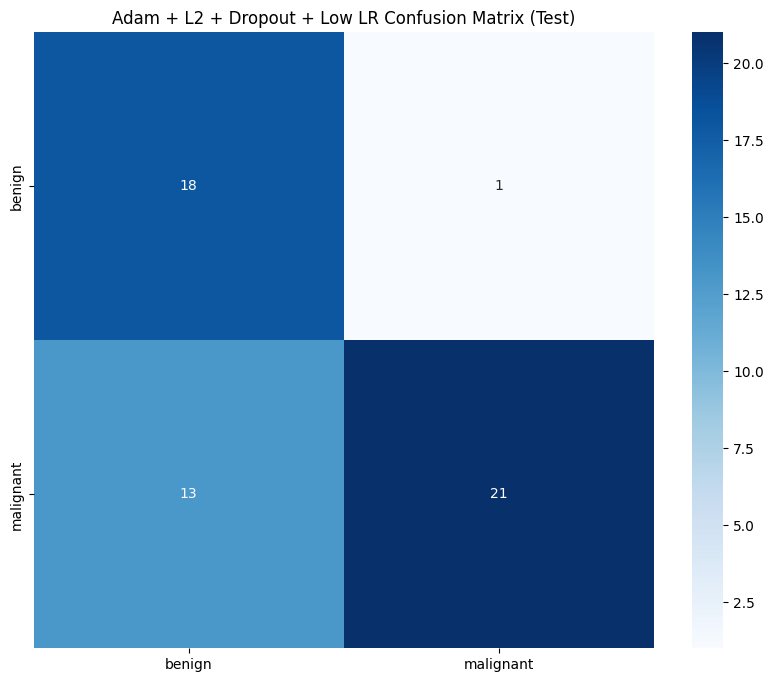

In [ ]:
# Stage 5: Train Neural Network Models

# Model 1: Simple Model (Instance 1, No Optimization)
model1, hist1 = define_model(
    optimization='adam', regularization_datatype=None, early_stopping=False, dropout=0.0, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model1.h5'
)
if hist1 is None:
    hist1 = model1.fit(train_gen, validation_data=val_gen, epochs=50, verbose=0)
loss_curve_plot(hist1, "Simple Model")
print_final_accuracy(hist1, "Simple Model")

y_pred_prob1 = model1.predict(test_gen)
y_pred1 = (y_pred_prob1 > 0.5).astype(int).flatten()
y_true = test_gen.classes
cm1 = confusion_matrix(y_true, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Simple Model Confusion Matrix (Post-Training)")
plt.show()





# Model 2: Adam + L2 + Dropout (Instance 2)
model2, hist2 = define_model(
    optimization='adam', regularization_datatype=l2(0.01), early_stopping=True, dropout=0.3, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model2.h5'
)
checkpoint2 = ModelCheckpoint('/content/drive/MyDrive/saved_models/model2_best.h5',
                              monitor='val_loss', save_best_only=True)
if hist2 is None:
    hist2 = model2.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=5), checkpoint2], verbose=0)
loss_curve_plot(hist2, "Adam + L2 + Dropout")
print_final_accuracy(hist2, "Adam + L2 + Dropout")

y_pred_prob2 = model2.predict(test_gen)
y_pred2 = (y_pred_prob2 > 0.5).astype(int).flatten()
cm2 = confusion_matrix(y_true, y_pred2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Adam + L2 + Dropout Confusion Matrix (Post-Training)")
plt.show()





# Model 3: RMSprop + L1 + Dropout (Instance 3)
model3, hist3 = define_model(
    optimization='rmsprop', regularization_datatype=l1(0.01), early_stopping=True, dropout=0.2, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model3.h5'
)
checkpoint3 = ModelCheckpoint('/content/drive/MyDrive/saved_models/model3_best.h5',
                              monitor='val_loss', save_best_only=True)
if hist3 is None:
    hist3 = model3.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=7), checkpoint3], verbose=0)
loss_curve_plot(hist3, "RMSprop + L1 + Dropout")
print_final_accuracy(hist3, "RMSprop + L1 + Dropout")

y_pred_prob3 = model3.predict(test_gen)
y_pred3 = (y_pred_prob3 > 0.5).astype(int).flatten()
cm3 = confusion_matrix(y_true, y_pred3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("RMSprop + L1 + Dropout Confusion Matrix (Post-Training)")
plt.show()





# Model 4: Adam + L2 + Dropout (Instance 4)
model4, hist4 = define_model(
    optimization='adam', regularization_datatype=l2(0.005), early_stopping=True, dropout=0.4, learning_rate=0.0005,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model4.h5'
)
checkpoint4 = ModelCheckpoint('/content/drive/MyDrive/saved_models/model4_best.h5',
                              monitor='val_loss', save_best_only=True)
if hist4 is None:
    hist4 = model4.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=10), checkpoint4], verbose=0)
loss_curve_plot(hist4, "Adam + L2 + Dropout")
print_final_accuracy(hist4, "Adam + L2 + Dropout")

y_pred_prob4 = model4.predict(test_gen)
y_pred4 = (y_pred_prob4 > 0.5).astype(int).flatten()
cm4 = confusion_matrix(y_true, y_pred4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Adam + L2 + Dropout Confusion Matrix (Post-Training)")
plt.show()




# Model 5: Adam + L2 + Dropout + Low LR (Instance 5)
model5, hist5 = define_model(
    optimization='adam', regularization_datatype=l2(0.01), early_stopping=True, dropout=0.5, learning_rate=0.0001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/optimized_cnn_model_4.h5'
)
checkpoint5 = ModelCheckpoint('/content/drive/MyDrive/saved_models/model5_best.h5',
                              monitor='val_loss', save_best_only=True)
if hist5 is None:
    hist5 = model5.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=12), checkpoint5], verbose=0)
loss_curve_plot(hist5, "Adam + L2 + Dropout + Low LR")
print_final_accuracy(hist5, "Adam + L2 + Dropout + Low LR")

y_pred_prob5 = model5.predict(test_gen)
y_pred5 = (y_pred_prob5 > 0.5).astype(int).flatten()
cm5 = confusion_matrix(y_true, y_pred5)
plt.figure(figsize=(10, 8))
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Adam + L2 + Dropout + Low LR Confusion Matrix (Post-Training)")
plt.show()




# Final Evaluation
models = [model1, model2, model3, model4, model5]
titles = ["Simple Model", "Adam + L2 + Dropout", "RMSprop + L1 + Dropout", "Adam + L2 + Dropout", "Adam + L2 + Dropout + Low LR"]

for model, title in zip(models, titles):
    y_pred_prob = model.predict(test_gen)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = test_gen.classes

    print(f"\n{title} Test Results:")
    print(classification_report(y_true, y_pred, target_names=['benign', 'malignant']))
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred_prob):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
    plt.title(f"{title} Confusion Matrix (Test)")
    plt.show()

## Task: Make Predictions using the best saved model

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:39:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

XGBoost Classification Report (Test Data):
              precision    recall  f1-score   support

      benign       1.00      0.95      0.97        19
   malignant       0.97      1.00      0.99        34

    accuracy                           0.98        53
   macro avg       0.99      0.97      0.98        53
weighted avg       0.98      0.98      0.98        53

XGBoost ROC AUC: 1.0000


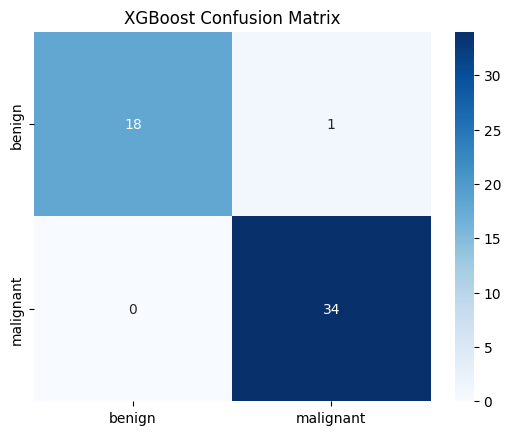

XGBoost model saved successfully.


In [ ]:
# Stage 6: XGBoost Model (Additional Comparison)
def load_data_from_folder(folder_path, target_size=(172, 251)):
    data = []
    labels = []
    for label in ['benign', 'malignant']:
        label_path = os.path.join(folder_path, label)
        for fname in os.listdir(label_path):
            if fname.endswith('.jpg'):
                img = Image.open(os.path.join(label_path, fname)).resize(target_size)
                data.append(np.array(img).flatten())
                labels.append(label)
    return np.array(data), np.array(labels)

X, y = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/train')
X_val, y_val = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/val')
X_test, y_test = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/test')

le = LabelEncoder()
y = le.fit_transform(y)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1_macro', cv=3, verbose=1, n_jobs=-1)
grid.fit(X, y)

print(f"\nXGBoost Best Parameters: {grid.best_params_}")

best_xgb_model = grid.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

print("\nXGBoost Classification Report (Test Data):")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
print(f"XGBoost ROC AUC: {roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1]):.4f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure()
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save XGBoost model as .pkl
joblib.dump(best_xgb_model, '/content/drive/MyDrive/saved_models/optimized_xgb_model.pkl')
print("XGBoost model saved successfully.")

In [ ]:
# Stage 7: Make Predictions with XGBoost Model
import os
import numpy as np
from PIL import Image
import joblib

def make_predictions(model_path, test_gen):
    # Load XGBoost model
    model = joblib.load(model_path)

    # Preprocess test_gen data (flatten images, no normalization to match Stage 6)
    data = []
    target_size = (172, 251)  # Match training preprocessing
    test_gen.reset()  # Reset generator to start
    for i in range(len(test_gen.filenames)):
        # Get image from generator
        img_array = next(test_gen)[0][0]  # Extract single image (batch_size=1)
        img = Image.fromarray((img_array * 255).astype(np.uint8)).resize(target_size)
        img_array = np.array(img).flatten()  # Flatten, no normalization
        data.append(img_array)

    # Convert to numpy array for scikit-learn
    X_test = np.array(data)

    # Make predictions
    prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class
    predictions = (prob > 0.5).astype(int)
    return model, predictions

best_model_path = '/content/drive/MyDrive/saved_models/optimized_xgb_model.pkl'
best_model, predictions = make_predictions(best_model_path, test_gen)

filenames = test_gen.filenames
for i in range(min(10, len(predictions))):
    print(f"Image: {filenames[i]}, Predicted: {'malignant' if predictions[i] else 'benign'}")

Image: benign/ISIC_1431322.jpg, Predicted: benign
Image: benign/ISIC_2596867.jpg, Predicted: benign
Image: benign/ISIC_3000299.jpg, Predicted: benign
Image: benign/ISIC_4258119.jpg, Predicted: benign
Image: benign/ISIC_4788959.jpg, Predicted: benign
Image: benign/ISIC_5083884.jpg, Predicted: benign
Image: benign/ISIC_5219984.jpg, Predicted: benign
Image: benign/ISIC_5731511.jpg, Predicted: benign
Image: benign/ISIC_5879786.jpg, Predicted: benign
Image: benign/ISIC_6574040.jpg, Predicted: benign
